In [1241]:
# Pkg.add("PyPlot")
# Pkg.add("TimeSeries")
# Pkg.add("MarketTechnicals")
# Pkg.add("DecisionTree")
# Pkg.add("ScikitLearn")
# Pkg.update()

In [1242]:
using Requests
using DataFrames
using TimeSeries
using MarketTechnicals
using PyPlot
using DecisionTree
using ScikitLearn

In [1243]:
function getcsv(url)
    # with error checking
    r = Requests.get_streaming(url; timeout = 30.0)
    if r.response.status / 100 != 2
        error("Error downloading data")
    end
    df = readtable(r)
end

function yahoo(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    if length(colnames)>=7
        pop!(colnames)
        deleteat!(colnames,1)
    end
    dataarray=convert(Array, df[1:end,[2,3,4,7,6]])
    ta=TimeArray(timestamp,dataarray,colnames)
end

function quandl(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    if length(colnames)>=6
        deleteat!(colnames,1)
    end
    dataarray=convert(Array, df[2:end])
    ta=TimeArray(timestamp,dataarray,colnames)
end

quandl (generic function with 1 method)

In [1244]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Float64,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Float64,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr"], ohlc.meta)
end

averagetruerange (generic function with 5 methods)

In [1245]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    merge(mcd, sig, col_names=["macd", "signal"])
end

macd2 (generic function with 4 methods)

In [1246]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Float64,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Float64,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pflow=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nflow=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pflow,sum,n)
    nsum=moving(nflow,sum,n)
    flowsum=psum.+nsum
    re=psum./flowsum
    TimeArray(re.timestamp, re.values, ["mfi"], ohlcv.meta)
end

moneyflowindex (generic function with 6 methods)

In [1247]:
function chaikinmoneyflow(ohlcv, n=20, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = ((cl.-lo).-(hi.-cl))./(hi.-lo).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf"], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [1248]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end

overlaps (generic function with 1 method)

In [1249]:
function mergetimearray(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

mergetimearray (generic function with 1 method)

In [1250]:
function pricerangeindex(ta, n=26)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=mergetimearray(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["pricerange"]])
end

pricerangeindex (generic function with 2 methods)

In [1251]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end

bollingerbands2 (generic function with 1 method)

In [1252]:
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=mergetimearray(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev", "bbstd"])
end

bollingerbands_deviation (generic function with 3 methods)

In [1253]:
function moneyflow_deviation(rsi, mfi)
    rm=mergetimearray(rsi,mfi)
    mfdev=TimeArray(rm.timestamp,rm.values[:,2]-rm.values[:,1],["moneyflowdev"])
    mfdevema=ema(mfdev,6)
    TimeArray(mfdevema.timestamp,mfdevema.values,["mfidev"])
end

moneyflow_deviation (generic function with 1 method)

In [1254]:
# Financial data sets
url1="http://real-chart.finance.yahoo.com/table.csv?s=TQQQ&a=0&b=1&c=2011&d=4&e=5&f=2016&g=d&ignore=.csv";
# tqqq=yahoo(url1)

"http://real-chart.finance.yahoo.com/table.csv?s=TQQQ&a=0&b=1&c=2011&d=4&e=5&f=2016&g=d&ignore=.csv"

In [1255]:
splitoffset=252-24;
url2="https://www.quandl.com/api/v3/datasets/GOOG/NASDAQ_TQQQ.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=2011-01-01&end_date=2016-05-05";
tqqq=quandl(url2)

1344x5 TimeSeries.TimeArray{Float64,2,DataType} 2011-01-03 to 2016-05-05

             Open      High      Low       Close     Volume         
2011-01-03 | 18.98     19.7      18.97     19.32     2780896        
2011-01-04 | 19.56     19.57     18.92     19.29     2739672        
2011-01-05 | 19.1      19.78     19.07     19.77     2559952        
2011-01-06 | 19.84     19.99     19.72     19.95     2177616        
⋮
2016-05-02 | 93.19     95.49     92.05     95.06     2454373        
2016-05-03 | 93.07     94.32     91.68     92.53     3023488        
2016-05-04 | 90.83     91.77     89.98     90.7      3205079        
2016-05-05 | 91.56     92.24     90.01     90.65     2999501        


In [1256]:
df=getcsv("https://www.quandl.com/api/v3/datasets/CBOE/VIX.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=2011-01-01")
timestamp = Date[Date(i) for i in df[1]] # parse dates
colnames=AbstractString[string(i) for i in DataFrames.names(df)]
dataarray=convert(Array, df[:,2:end])
vixarray=TimeArray(timestamp,dataarray[:,end],[colnames[end]])

1343x1 TimeSeries.TimeArray{Float64,1,DataType} 2011-01-03 to 2016-05-04

             VIX_Close  
2011-01-03 | 17.61      
2011-01-04 | 17.38      
2011-01-05 | 17.02      
2011-01-06 | 17.4       
⋮
2016-04-29 | 15.7       
2016-05-02 | 14.68      
2016-05-03 | 15.6       
2016-05-04 | 16.05      


In [1257]:
ta=tqqq["Close"];
rsiarray=rsi(ta)./100;
rsi26array=rsi(ta,26)./100;

In [1258]:
atrarray=averagetruerange(tqqq);
atr26array=averagetruerange(tqqq,26);

In [1259]:
# h="High"
# l="Low"
# c="Close"
# v="Volume"
# ohlcv=tqqq
# hi=ohlcv[h]
# lo=ohlcv[l]
# cl=ohlcv[c]
# # volume=ohlcv[v]

In [1260]:
mfiarray=moneyflowindex(tqqq);
mfi26array=moneyflowindex(tqqq,26);

In [1261]:
macdarray=macd2(ta);
cmfarray=chaikinmoneyflow(tqqq);
bbarray=bollingerbands_deviation(ta);
mfidevarray=moneyflow_deviation(rsiarray, mfiarray)
rangeindexarray=pricerangeindex(ta);

In [1262]:
featurearray=mergetimearray(atrarray,rsiarray);

In [1263]:
featurearray=mergetimearray(featurearray,mfiarray);

In [1264]:
featurearray=mergetimearray(featurearray,mfidevarray);

In [1265]:
featurearray=mergetimearray(featurearray,cmfarray);

In [1266]:
featurearray=mergetimearray(featurearray,bbarray);

In [1267]:
featurearray=mergetimearray(featurearray,macdarray);

In [1268]:
featurearray=mergetimearray(featurearray,atr26array);
featurearray=mergetimearray(featurearray,rsi26array);
featurearray=mergetimearray(featurearray,mfi26array);

In [1269]:
featurearray=mergetimearray(featurearray,vixarray);

In [1270]:
featurearray1=mergetimearray(featurearray,rangeindexarray);

In [1271]:
featurearray2=mergetimearray(featurearray,ta);

In [1272]:
splitdate=featurearray1.timestamp[end]

2016-03-31

In [1273]:
sidx=searchsortedfirst(featurearray2.timestamp, splitdate)-splitoffset

1058

In [1274]:
oldfeatures=TimeArray(featurearray1.timestamp[1:sidx],featurearray1.values[1:sidx,:],featurearray1.colnames)

1058x17 TimeSeries.TimeArray{Float64,2,DataType} 2011-02-18 to 2015-05-05

             atr     rsi     mfi     mfidev  cmf     bbdev   bbstd   macd    signal  atr     rsi     mfi     VIX_Close  Close     min       max       pricerange  
2011-02-18 | 0.6271  0.7423  0.9028  -0.0482 0.4007  0.6464  1.042   0.8073  0.6967  0.6607  0.6799  0.5417  16.43      23.0      17.82     23.0      1.0         
2011-02-22 | 0.7337  0.332   0.3897  -0.018  0.2649  -0.3465 1.0202  0.6355  0.6845  0.7168  0.4329  0.4069  20.8       20.97     17.82     22.29     0.7047      
2011-02-23 | 0.7678  0.2854  0.3103  -0.0057 0.2071  -0.595  1.0265  0.4522  0.638   0.7358  0.3933  0.3648  22.13      20.45     17.82     22.29     0.5884      
2011-02-24 | 0.7808  0.3446  0.3201  -0.0111 0.2227  -0.4478 1.0323  0.3265  0.5757  0.744   0.425   0.3592  21.32      20.74     17.82     22.29     0.6532      
⋮
2015-04-30 | 3.9586  0.4106  0.3899  -0.0352 0.0813  -0.101  4.3399  1.9862  1.7238  3.7706  0.4786  0.3855 

In [1275]:
newfeatures=TimeArray(featurearray2.timestamp[sidx+1:end],featurearray2.values[sidx+1:end,:],featurearray2.colnames)

252x14 TimeSeries.TimeArray{Float64,2,DataType} 2015-05-06 to 2016-05-04

             atr     rsi     mfi     mfidev  cmf     bbdev   bbstd    macd    signal  atr     rsi     mfi     VIX_Close  Close     
2015-05-06 | 4.1505  0.3619  0.341   -0.0427 -0.0354 -0.6936 3.588    0.8571  1.5475  3.9017  0.4343  0.3838  15.15      105.42    
2015-05-07 | 4.0741  0.4211  0.3989  -0.0368 -0.0453 -0.4345 3.6111   0.5444  1.3469  3.8701  0.4655  0.4029  15.13      107.23    
2015-05-08 | 4.1202  0.5303  0.4247  -0.0565 -0.0685 0.0956  3.6028   0.6066  1.1988  3.9028  0.5266  0.47    12.86      111.16    
2015-05-11 | 4.0002  0.4967  0.3932  -0.0699 -0.076  -0.0859 3.5707   0.5512  1.0693  3.8465  0.5072  0.4652  13.85      109.94    
⋮
2016-04-29 | 3.9478  0.1889  0.2471  0.0373  0.0105  -1.2044 4.1821   -0.3994 1.4704  4.0949  0.3379  0.4298  15.7       92.61     
2016-05-02 | 3.9115  0.324   0.2876  0.0162  0.0591  -0.7994 4.473    -0.754  1.0255  4.0697  0.4001  0.454   14.68      95.06     


In [1276]:
closeidx=findfirst(oldfeatures.colnames,"Close")

14

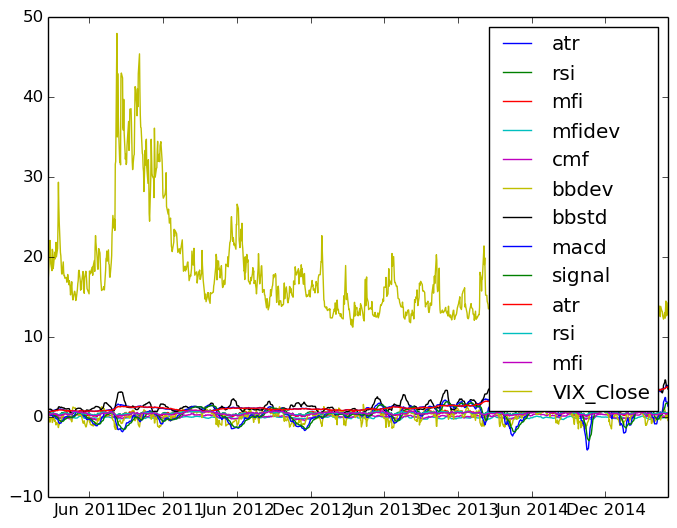

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [1277]:
plot(oldfeatures.timestamp,oldfeatures.values[:,1:closeidx-1])
legend(oldfeatures.colnames[1:closeidx-1])

In [1278]:
using DecisionTree
using ScikitLearn
using PyPlot

In [1279]:
ntrees=100
pricerangeidx=closeidx+3
features=oldfeatures.values[:,1:closeidx]
labels=oldfeatures.values[:,pricerangeidx]
model = build_forest(labels,features, 2, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 250.53
Avg Depth:  19.67

In [1280]:
newlabels=apply_forest(model, newfeatures.values);

In [1281]:
initvalue=oldfeatures.values[1,closeidx]*2

46.0

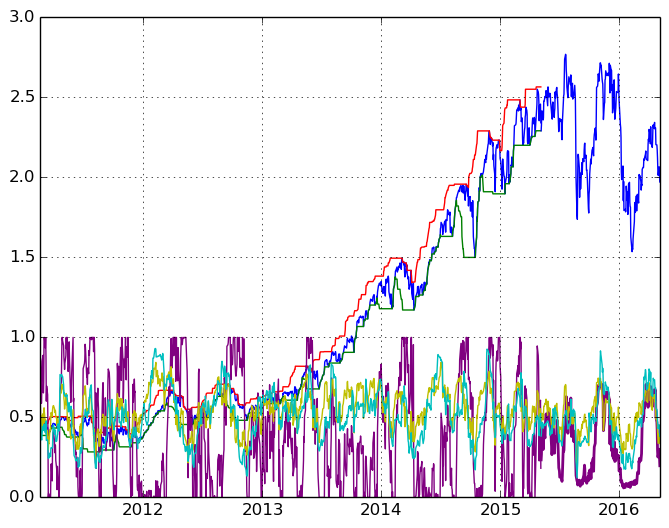

In [1282]:
plot(oldfeatures.timestamp,oldfeatures.values[:,closeidx:pricerangeidx-1]./initvalue)
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot(oldfeatures.timestamp,labels,c="Purple")
plot(newfeatures.timestamp,newlabels,c="Purple",linewidth=2)
plot(oldfeatures.timestamp,oldfeatures.values[:,11],c="y")
plot(newfeatures.timestamp,newfeatures.values[:,11],c="y")
plot(oldfeatures.timestamp,oldfeatures.values[:,12],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,12],c="c")
grid("on")

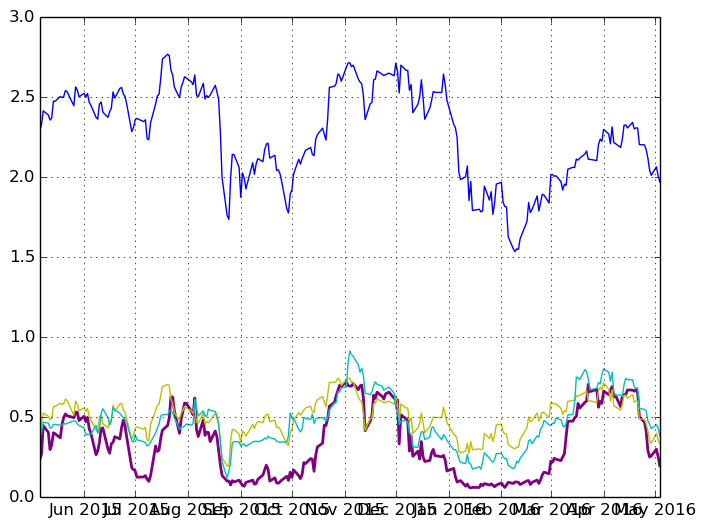

In [1283]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot(newfeatures.timestamp,newlabels,c="Purple",linewidth=2)
# plot(newfeatures.timestamp,newfeatures.values[:,2],c="y")
# plot(newfeatures.timestamp,newfeatures.values[:,3],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,11],c="y")
plot(newfeatures.timestamp,newfeatures.values[:,12],c="c")
grid("on")